In [55]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

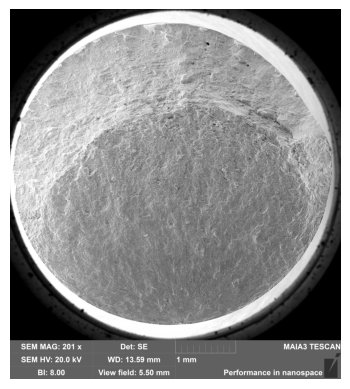

In [56]:
# Read the image
img = cv2.imread('C:\\Users\\yoni mazin\\Downloads\\images/P2MF3_C_01.tif',cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # color conversion from rgb to grayscale
_, width = gray.shape # '.shape' retrieve tuple which represent height and width. the underscore
                      # "_" is used to discard the height information
plt.axis('off') # hide the axis of the plot
plt.imshow(img)
plt.show()
# we need the two last lines of code because 'plt.imshow(img)' is like prepare the content that we want to display
# and 'plt.show()' is to actually display this content

In [57]:
img.shape

(4576, 4096, 3)

Now we want to remove the bottom bar.To do so, we know that the image itself without the bottom bar is actually a square, so we crop the bottom bar by crop the height to be as the width of the image

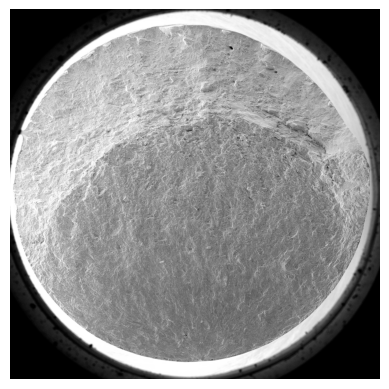

In [58]:
# Remove bottom bar
img = img[0:width, 0:width]
gray = gray[0:width, 0:width]
plt.axis('off')
plt.imshow(img)
plt.show()

In [59]:
img.shape # now we can see that it is actually a square

(4096, 4096, 3)

Our next purpose is to remove the background because it is unnecassary data.
For doing so, we first binarize the image (with some threshold) so that the lens contour will become more distinct. 
The threshold that we select is 150 as we can see.

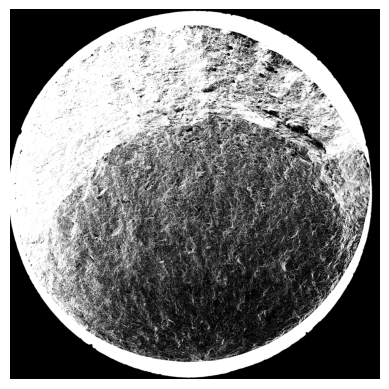

In [60]:
# first, we gonna make copies for ensure that the original images are not modified
img_s = img.copy()
gray_s = gray.copy()

# apply threshold to binarize the image. 
# Every pixel above 150 will be set to 255 (white) and every pixel below will be set to 0 (black)
_, thresh = cv2.threshold(gray_s, 150, 255, cv2.THRESH_BINARY) # threshold function returns tuple and we omit the first one

plt.imshow(thresh, cmap='gray') # 'cmap = gray' is suitable for displaying binary images where 0 is black and 255 is white
plt.axis('off')
plt.show()

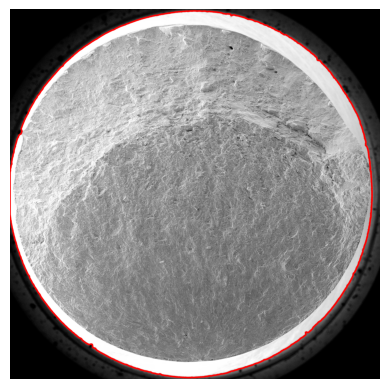

In [61]:
# find contours (boundaries of object within an image) in the binary image.
# The 'cv2.RETR_EXTERNAL' extract only the external contours (those not contained within other contours).
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# draw the largest contour on the original image.
# we use cv2.contourArea for find the largerst contour area
largest_contour = max(contours, key=cv2.contourArea)

# convert the image to RGB instead of BGR. It is done because it's the standard 
# for most image processing and display libraries include matplotlib.
img_clean = cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB)

# draw the contour on the original image.
# (255,0,0) represent the red color and 15 represent the thickness of the contour.
cv2.drawContours(img_s, [largest_contour], -1, (255, 0, 0), 15)

# Display the image with the detected circles
plt.axis('off')
plt.imshow(img_s)
plt.show()

Now we want to remove the unessacery black background

In [62]:
# find the center of the contour using moments, we can think of that like find the balance point of the shape.
M = cv2.moments(largest_contour)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])
center = (cx, cy)

# define a scaling factor.
# This factor determines how much the contour should be scaled, either enlarged or reduced.
k = 0.98

# create an empty list for the new contour points
new_cnt = []

# loop through each point of the contour
for pt in largest_contour:
    # get the x and y coordinates
    x = pt[0][0]
    y = pt[0][1]

    # shift the point to the origin
    x -= cx
    y -= cy

    # scale the point by the factor k
    x *= k
    y *= k

    # shift the point back to the center
    x += cx
    y += cy

    # append the new point to the list
    new_cnt.append([[int(x), int(y)]])

# convert the list to a numpy array
new_cnt = np.array(new_cnt)

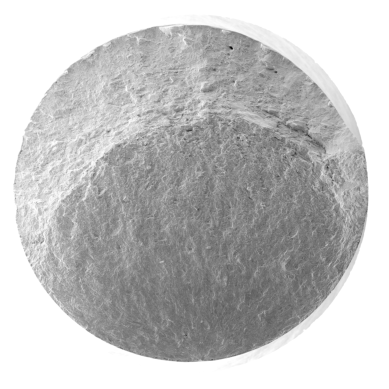

In [63]:
gray_c = gray.copy()

# Make all pixels outside the contour white
mask = np.zeros_like(gray_c)
cv2.drawContours(mask, [new_cnt], -1, 255, -1)

out = np.zeros_like(gray_c)
gray_r = cv2.bitwise_not(gray_c)
out[mask == 255] = gray_r[mask == 255]
out = cv2.bitwise_not(out)

# Display the image with the detected circles
plt.axis('off')
plt.imshow(out, cmap='gray')
plt.show()

out_c = out.copy()

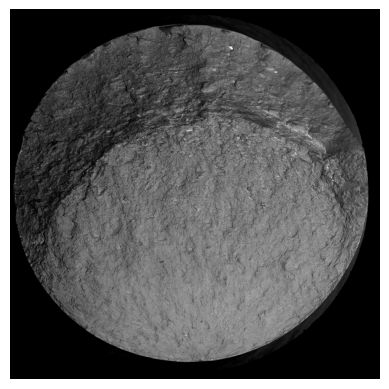

In [64]:
#find the negative of the gray image
gray_s = cv2.bitwise_not(out_c)

plt.imshow(gray_s, cmap='gray')
plt.axis('off')
plt.show()

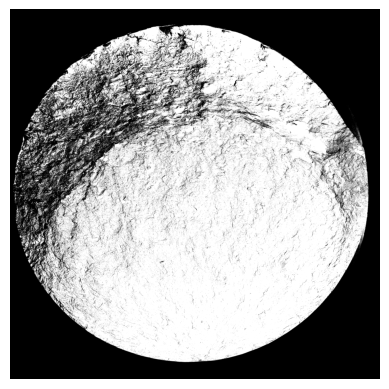

In [65]:
# apply threshold to binarize the image
_, thresh = cv2.threshold(gray_s, 57, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

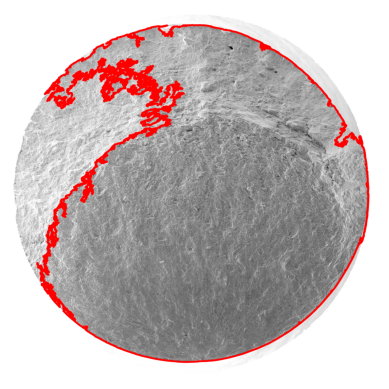

Area of the broken surface:  9619388.5 pixels


In [66]:
# find contours in the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# draw the largest contour on the original image
largest_contour = max(contours, key=cv2.contourArea)

# convert the image to RGB
img_clean = cv2.cvtColor(out_c, cv2.COLOR_BGR2RGB)

# draw the contour on the original image
cv2.drawContours(img_clean, [largest_contour], -1, (255, 0, 0), 20)

# show the result
plt.imshow(img_clean)
plt.axis('off')
plt.show()

# find the area of the largest contour
area = cv2.contourArea(largest_contour)
print("Area of the broken surface: ", area, "pixels")

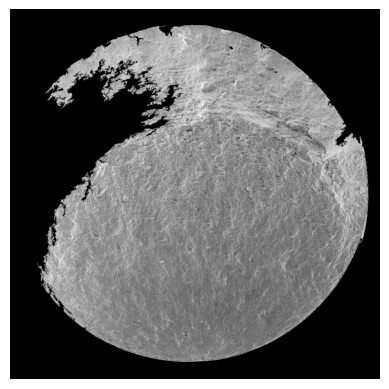

In [67]:
# remove all pixels outside the contour
mask_metal = np.zeros_like(gray_c)
cv2.drawContours(mask_metal, [largest_contour], -1, 255, -1)
out = np.zeros_like(gray_c)
out[mask_metal == 255] = gray[mask_metal == 255]

# Save the image
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\clean_image.jpg', out)

plt.imshow(out, cmap='gray')
plt.axis('off')
plt.show()

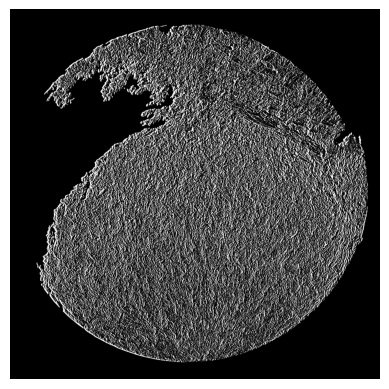

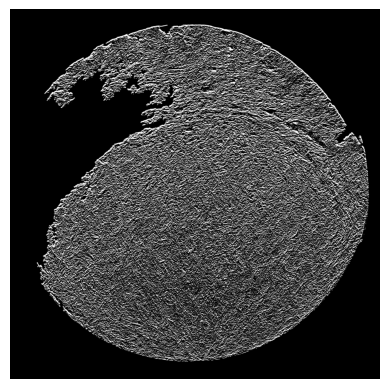

In [68]:
# Convert the out image to RGB
img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)


# Two dimensional Sobel filter

img_RGB = img_color.copy()
# Convert to grayscale
img_grey = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
img_gauss = cv2.GaussianBlur(img_grey, (13,13), 0)

# Run Sobel filter on the original image
sobelx = cv2.Sobel(img_gauss, cv2.CV_8U, 1, 0, ksize=5)
sobely = cv2.Sobel(img_gauss, cv2.CV_8U, 0, 1, ksize=5)

# Save the image
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\sobelx.jpg', sobelx)
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\sobely.jpg', sobely)

plt.imshow(sobelx, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(sobely, cmap='gray')
plt.axis('off')
plt.show()

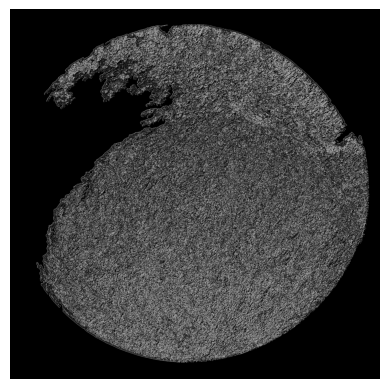

In [69]:
# Find the magnitude of the gradient
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

# Normalize the image
sobel_magnitude = sobel_magnitude/sobel_magnitude.max()*255

# Convert to uint8
sobel_magnitude = np.uint8(sobel_magnitude)

# Save the image
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\sobel_magnitude.jpg', sobel_magnitude)

plt.imshow(sobel_magnitude, cmap='gray')
plt.axis('off')
plt.show()

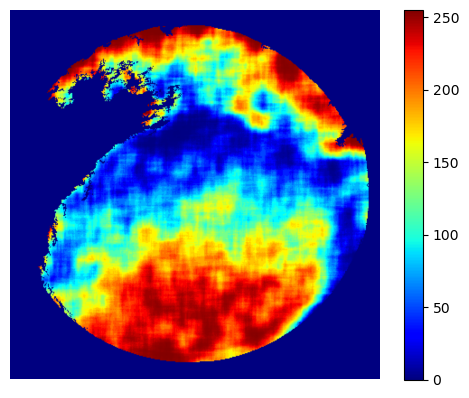

In [70]:
# Sliding window over sobel image in two dimensions to create a heatmap of the edges

window_size = 201 # Odd number only
window_step = 10

heat_map_sobel = np.zeros(sobel_magnitude.shape, dtype=np.uint8)

# pad the images with zeros
sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
mask_metal_c = np.pad(mask_metal, int((window_size-1)/2), mode='constant', constant_values=0)

for y in range(0, sobel_c.shape[0], window_step):
    for x in range(0, sobel_c.shape[1], window_step):
        window = sobel_c[y:y+window_size, x:x+window_size]
        mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
        if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
            heat_map_sobel[y:y+window_size, x:x+window_size] = 0
        else:
            heat_map_sobel[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

heat_map_sobel = cv2.equalizeHist(heat_map_sobel)

# Save the image with color map
heat_map_sobel_tmp = heat_map_sobel.copy()
heat_map_color_sobel = cv2.applyColorMap(heat_map_sobel_tmp, cv2.COLORMAP_JET)
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\heat_map_sobel.jpg', heat_map_color_sobel)
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\heat_map_sobel_gray.jpg', heat_map_sobel_tmp)

heat_map_color_sobel_rgb = cv2.cvtColor(heat_map_color_sobel, cv2.COLOR_BGR2RGB)

plt.imshow(heat_map_color_sobel_rgb, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

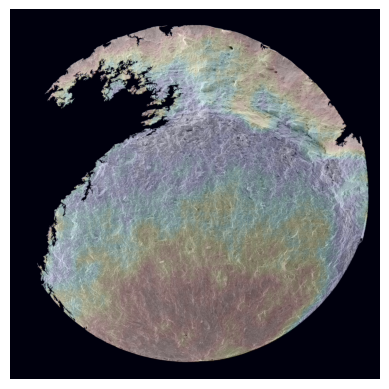

In [71]:
# Show the heat map on the original image with transparency
alpha = 0.1
# Convert the out image to RGB
img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
img_hm = img_color.copy()
cv2.addWeighted(heat_map_color_sobel, alpha, img_hm, 1-alpha, 0, img_hm)

# Save the image
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\heat_map_on_image_sobel.jpg', img_hm)

plt.imshow(cv2.cvtColor(img_hm, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Text(0, 0.5, 'Sobel Magnitude')

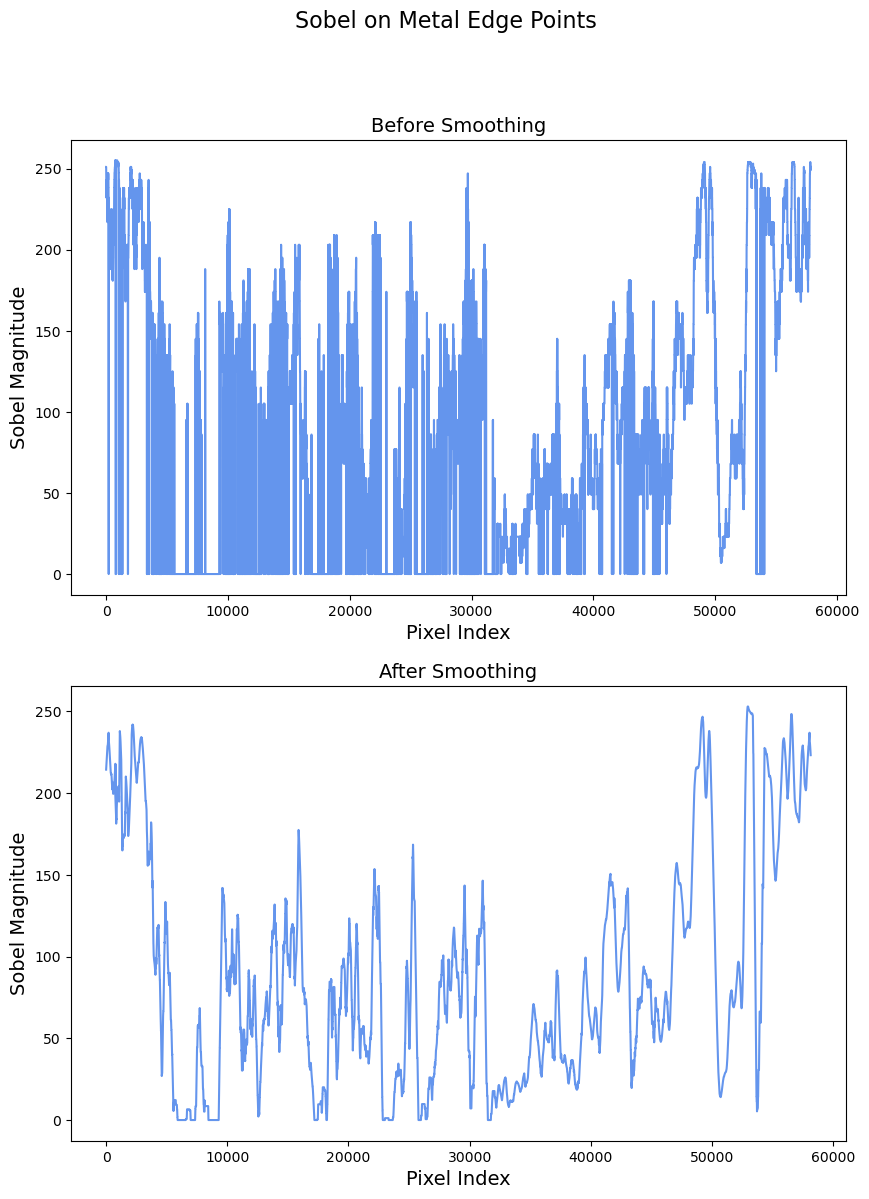

In [72]:
# Find start and end points of the shortest path
center = [int((heat_map_sobel.shape[0])/2), int((heat_map_sobel.shape[1])/2)]
metal_contour = 0.96*(largest_contour[:,0,:]-center)+center
# convert to int
metal_contour = metal_contour.astype(int)

# Sample heat_map_sobel at largest_contour to find the metal edge points
metal_edge_points = heat_map_sobel[metal_contour[:,1], metal_contour[:,0]]

# Smooth the curve using circular convolution
kernel_size = 300
#window = np.ones(window_size)/window_size
#metal_edge_points_smooth = np.convolve(metal_edge_points, window, mode='same')

kernel = np.ones(kernel_size) / kernel_size
padded_vector = np.pad(metal_edge_points, (kernel_size - 1, kernel_size - 1), mode='wrap')
metal_edge_points_smooth = np.convolve(padded_vector, kernel, mode='valid')

fig, ax = plt.subplots(2,figsize=(10,13))

fig.suptitle('Sobel on Metal Edge Points', fontsize=16)
ax[0].plot(metal_edge_points[:], '-', color='cornflowerblue')
ax[0].set_title('Before Smoothing', fontsize=14)
ax[0].set_xlabel('Pixel Index', fontsize=14)
ax[0].set_ylabel('Sobel Magnitude', fontsize=14)
ax[1].plot(metal_edge_points_smooth[:], '-', color='cornflowerblue')
ax[1].set_title('After Smoothing', fontsize=14)
ax[1].set_xlabel('Pixel Index', fontsize=14)
ax[1].set_ylabel('Sobel Magnitude', fontsize=14)

In [73]:
# Find the index of the minimum value in the smoothed curve
min_index_1 = np.argmin(metal_edge_points_smooth)

no_search_window = 0.2 # Fraction of the total length of the curve
# Find second minimum value in the smoothed curve outside the search window
metal_edge_points_smooth_2 = metal_edge_points_smooth.copy()
metal_edge_points_smooth_2[min_index_1-int(no_search_window/2*len(metal_edge_points_smooth)):min_index_1+int(no_search_window/2*len(metal_edge_points_smooth))] = 255
min_index_2 = np.argmin(metal_edge_points_smooth_2)

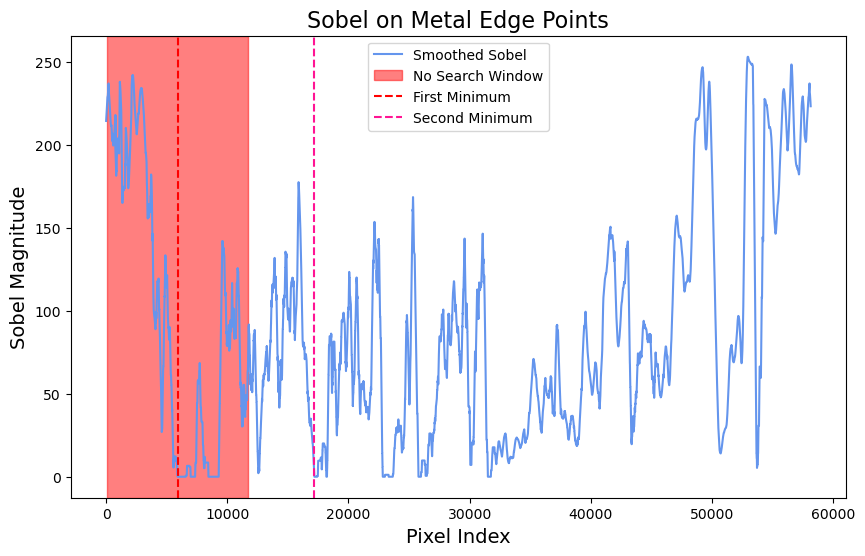

In [74]:
# Show on the smoothed curve the minimum values and the search window
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(metal_edge_points_smooth[:], '-', color='cornflowerblue', label='Smoothed Sobel')
ax.set_title('Sobel on Metal Edge Points', fontsize=16)
ax.set_xlabel('Pixel Index', fontsize=14)
ax.set_ylabel('Sobel Magnitude', fontsize=14)
ax.axvspan(min_index_1-int(no_search_window/2*len(metal_edge_points_smooth)), min_index_1+int(no_search_window/2*len(metal_edge_points_smooth)), alpha=0.5, color='red', label='No Search Window')
ax.axvline(x=min_index_1, color='red', linestyle='--', label='First Minimum')
ax.axvline(x=min_index_2, color='deeppink', linestyle='--', label='Second Minimum')
plt.legend()
plt.show()

In [75]:
img_shortest_path = img_color.copy() # Original image
img_sobel_shortest_path = heat_map_color_sobel.copy() # Sobel heat map in colors
img_sobel_shortest_path_gray = heat_map_sobel.copy() # Sobel heat map in grayscale

factor = 0.1 # Resize factor
heat_map_sobel_resized = cv2.resize(heat_map_sobel, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
mask_metal_resized = cv2.resize(mask_metal, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
img_shortest_path = cv2.resize(img_shortest_path, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
img_sobel_shortest_path = cv2.resize(img_sobel_shortest_path, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
img_sobel_shortest_path_gray = cv2.resize(img_sobel_shortest_path_gray, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)

# Increase the pixels in heat_map_sobel_resized that are within the mask by 1
heat_map_sobel_resized[mask_metal_resized > 0] += 1
# Set all pixels in heat_map_sobel_resized that are bigger than 255 to 255
heat_map_sobel_resized[heat_map_sobel_resized > 255] = 255

In [76]:
import heapq

def dijkstra(image, start, end, path_factor=0.1):

  if(image[start[0], start[1]] == 0):
    print("start point is black")
    return []
  if(image[end[0], end[1]] == 0):
    print("end point is black")
    return []

  # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Create a graph where each node is a pixel in the image.
  graph = {}
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      graph[i, j] = []

  # Add edges to the graph for each pair of adjacent pixels.
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
          if di != 0 or dj != 0:
            ni = i + di
            nj = j + dj
            if 0 <= ni < image_array.shape[0] and 0 <= nj < image_array.shape[1]:
              graph[i, j].append((ni, nj))

  # Initialize the distance from the start point to all other points to infinity.
  distances = {}
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      distances[i, j] = np.inf
     # Set the distance from the start point to itself to 0.
  distances[start[0], start[1]] = 0

  # Use Dijkstra's algorithm to find the shortest path from the start point to the end point.
  queue = [(0, start)]
  while queue:
    current_distance, current_node = heapq.heappop(queue)
    if current_node == end:
      break
    for neighbor in graph[current_node]:
      if(image[neighbor[0], neighbor[1]] == 0):
        continue
      new_distance = current_distance + image[neighbor[0], neighbor[1]]/255 + path_factor
      if distances[neighbor] > new_distance:
        distances[neighbor] = new_distance
        heapq.heappush(queue, (new_distance, neighbor))

  # Return the shortest path from the start point to the end point.
  path = []
  current_node = end
  while current_node != start:
    path.append(current_node)
    for neighbor in graph[current_node]:
      if distances[neighbor] < distances[current_node]:
        current_node = neighbor
        break

  path.append(start)
  path.reverse()
  return path

(113, 63) (97, 119)
start point is black


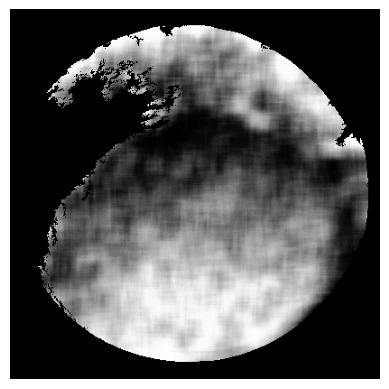

<Figure size 640x480 with 0 Axes>

In [77]:
# Find the shortest path between two points
start = (int(metal_contour[min_index_1][1]*factor), int(metal_contour[min_index_1][0]*factor))
end = (int(metal_contour[min_index_2][1]*factor), int(metal_contour[min_index_2][0]*factor))
print(start, end)

path = dijkstra(heat_map_sobel_resized, start, end, 0)

# Create image copies
img_sobel_shortest_path_gray1 = cv2.cvtColor(img_sobel_shortest_path_gray, cv2.COLOR_GRAY2BGR)
img_sobel_shortest_path1 = img_sobel_shortest_path.copy()
img_shortest_path1 = img_shortest_path.copy()

# Display the path.
half_line_width = 1
for i in range(len(path) - 1):
    img_sobel_shortest_path_gray1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (255, 0,0)
    img_shortest_path1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (255, 0,0)
    img_sobel_shortest_path1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = 255

# Show the result
plt.axis('off')
plt.imshow(img_sobel_shortest_path_gray1, cmap='gray')
plt.show()
plt.savefig('C:\\Users\\yoni mazin\\Downloads\\temp\\img_sobel_shortest_path_gray1.png')

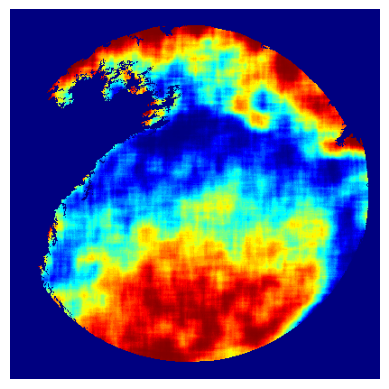

<Figure size 640x480 with 0 Axes>

In [78]:
plt.axis('off')
plt.imshow(cv2.cvtColor(img_sobel_shortest_path1, cv2.COLOR_BGR2RGB))
plt.show()
plt.savefig('C:\\Users\\yoni mazin\\Downloads\\temp\\img_sobel_shortest_path1.png')

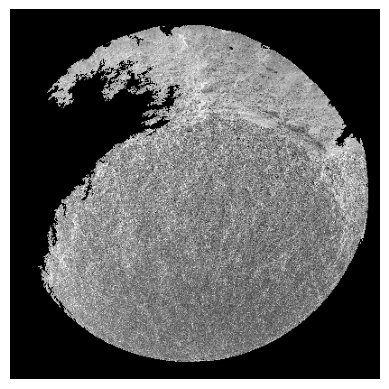

<Figure size 640x480 with 0 Axes>

In [79]:
plt.axis('off')
plt.imshow(img_shortest_path1, cmap='gray')
plt.show()
plt.savefig('C:\\Users\\yoni mazin\\Downloads\\temp\\img_shortest_path1.png')

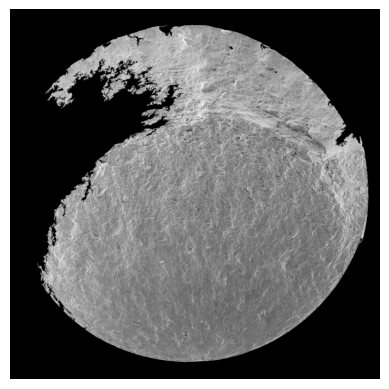

True

In [80]:
# Plot the shortest path on  image color
img_shortest_path_clean = img_color.copy()

# place lines on the image between two path points
for i in range(len(path) - 1):
    cv2.line(img_shortest_path_clean, (round(path[i][1]/factor), round(path[i][0]/factor)), (round(path[i+1][1]/factor), round(path[i+1][0]/factor)), (0, 0, 255), 7)


plt.axis('off')
plt.imshow(cv2.cvtColor(img_shortest_path_clean, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('C:\\Users\\yoni mazin\\Downloads\\temp\\img_shortest_path_clean.png', img_shortest_path_clean)